In [2]:
import pandas as pd

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2


In [5]:
meta_path = "../data/raw/HAM10000_metadata.csv"
meta = pd.read_csv(meta_path)
meta.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:

meta['dx'].value_counts()


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

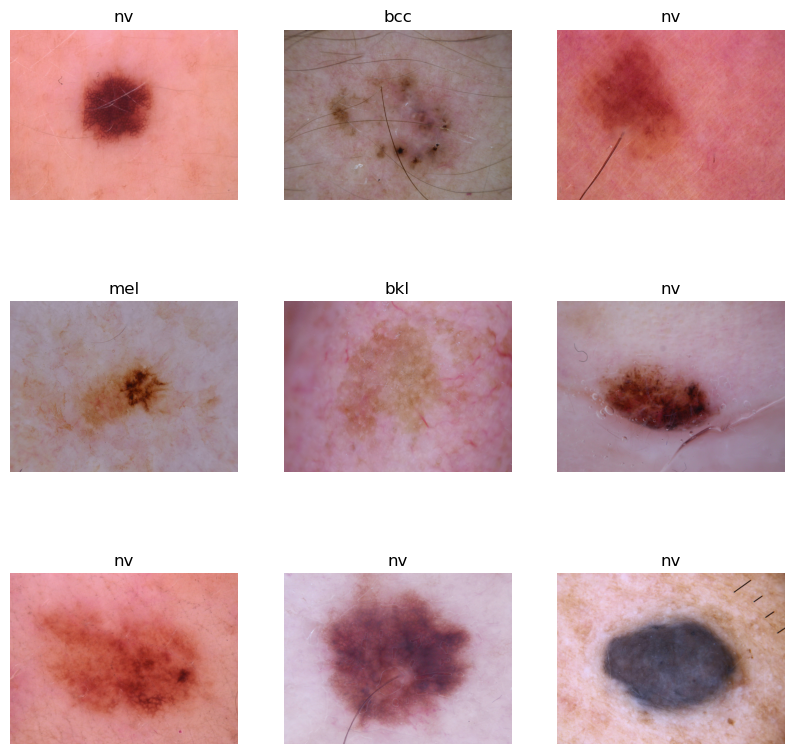

In [7]:
import matplotlib.pyplot as plt
import cv2

img_dir1 = "../data/raw/HAM10000_images_part_1/"
img_dir2 = "../data/raw/HAM10000_images_part_2/"

sample = meta.sample(9)

plt.figure(figsize=(10,10))
for i, (_, row) in enumerate(sample.iterrows()):
    img_id = row['image_id'] + ".jpg"
    
    if os.path.exists(img_dir1 + img_id):
        img_path = img_dir1 + img_id
    else:
        img_path = img_dir2 + img_id

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(row['dx'])
    plt.axis("off")

plt.show()


In [8]:
def get_path(img_id):
    img_file = img_id + ".jpg"
    
    if os.path.exists(img_dir1 + img_file):
        return img_dir1 + img_file
    else:
        return img_dir2 + img_file

meta['image_path'] = meta['image_id'].apply(get_path)
meta.head()



,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/raw/HAM10000_images_part_1/ISIC_002741...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../data/raw/HAM10000_images_part_1/ISIC_002503...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/raw/HAM10000_images_part_1/ISIC_002676...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../data/raw/HAM10000_images_part_1/ISIC_002566...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/raw/HAM10000_images_part_2/ISIC_003163...


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
meta['label'] = le.fit_transform(meta['dx'])
classes = le.classes_

classes



array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    meta,
    test_size=0.2,
    random_state=42,
    stratify=meta['label']  # ensures balanced split
)

len(train_df), len(val_df)


(8012, 2003)

In [12]:
IMG_SIZE = 224

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img


In [14]:
import tensorflow as tf

def df_to_dataset(df, batch_size=32, shuffle=True):
    paths = df['image_path'].values
    labels = df['label'].values

    def load_one(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda x, y: load_one(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [15]:
batch_size = 32

train_ds = df_to_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = df_to_dataset(val_df, batch_size=batch_size, shuffle=False)


In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

num_classes = 7

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base for Phase 1

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.summary()


16705208/16705208 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable 

In [17]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
251/251 [==============================] - 234s 901ms/step - loss: 1.1627 - accuracy: 0.6651 - val_loss: 1.1365 - val_accuracy: 0.6695
Epoch 2/5
251/251 [==============================] - 227s 903ms/step - loss: 1.1454 - accuracy: 0.6695 - val_loss: 1.1543 - val_accuracy: 0.6695
Epoch 3/5
251/251 [==============================] - 2527s 10s/step - loss: 1.1500 - accuracy: 0.6695 - val_loss: 1.1394 - val_accuracy: 0.6695
Epoch 4/5
251/251 [==============================] - 219s 870ms/step - loss: 1.1457 - accuracy: 0.6695 - val_loss: 1.1460 - val_accuracy: 0.6695
Epoch 5/5
251/251 [==============================] - 202s 803ms/step - loss: 1.1469 - accuracy: 0.6695 - val_loss: 1.1467 - val_accuracy: 0.6695


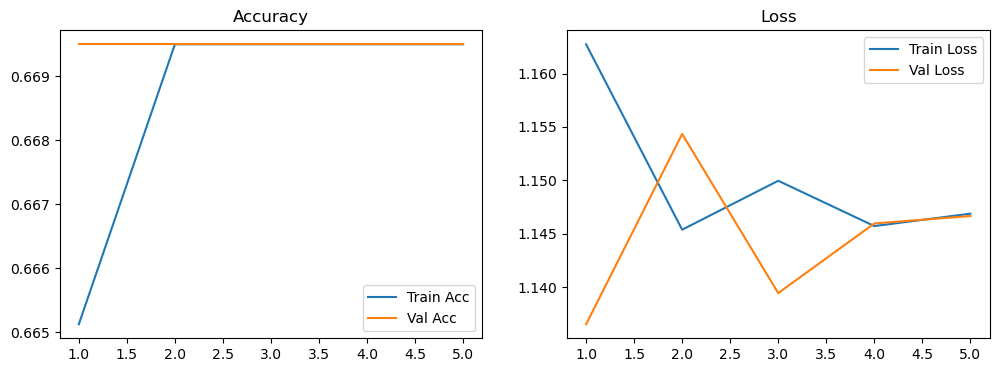

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


1/1 [==============================] - 0s 392ms/step


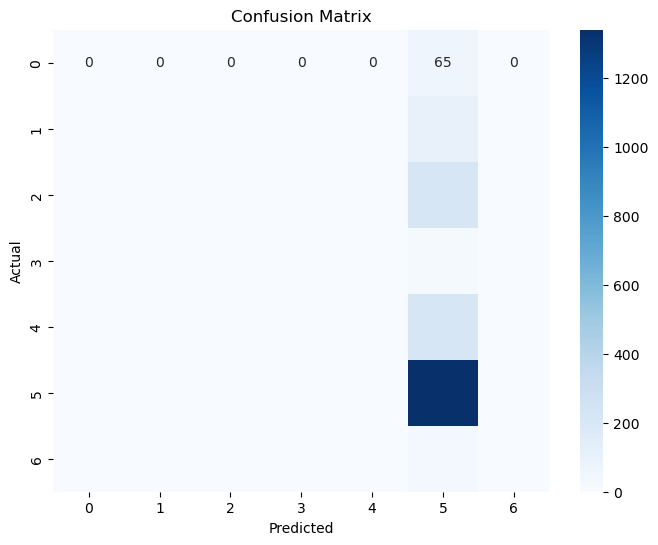

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

for imgs, labels in val_ds:
    preds = model.predict(imgs)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [33]:
import tensorflow as tf
tf.saved_model.save(model, "../outputs/Major_savedmodel_v1")


INFO:tensorflow:Assets written to: ../outputs/Major_savedmodel_v1\assets


INFO:tensorflow:Assets written to: ../outputs/Major_savedmodel_v1\assets


In [35]:
code = r'''
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def build_model(num_classes=7, input_shape=(224,224,3), dropout=0.2):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

# quick test (optional): 
# if __name__ == "__main__":
#     m = build_model()
#     m.summary()
'''
open("../outputs/build_model.py","w").write(code)
print("build_model.py created at ../outputs/build_model.py")


build_model.py created at ../outputs/build_model.py


In [36]:
# restore architecture + weights
import sys
sys.path.append("../outputs")   # so Python can import build_model.py
from build_model import build_model

m = build_model(num_classes=7, input_shape=(224,224,3))
m.load_weights("../outputs/Major_weights_v1.h5")
# test predict on one sample
# x = preprocess("...path...")  # same preprocess as before
# print(m.predict(x))


In [37]:
# meta
import json
meta = {"model":"EfficientNetB0","dataset":"HAM10000","epochs":5,"img_size":224,"classes":list(le.classes_)}
open("../outputs/Major_meta_v1.json","w").write(json.dumps(meta, indent=2))

# requirements (run in terminal)
# pip freeze > ../outputs/requirements.txt


187

Using image: ../data/raw/HAM10000_images_part_1/ISIC_0024321.jpg
Model loaded (builder + weights).
1/1 [==============================] - 1s 1s/step


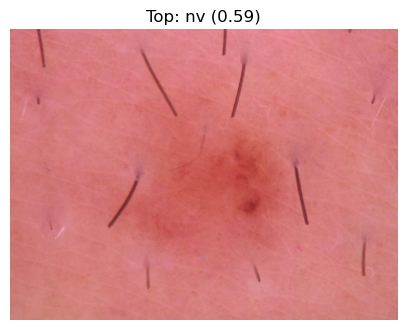

Top-3 predictions:
1. nv  —  0.5891
2. bkl  —  0.1507
3. mel  —  0.1354


In [46]:
# Find an actual image and run the single-image inference automatically
import os, sys, numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# image folders
img_dir1 = "../data/raw/HAM10000_images_part_1/"
img_dir2 = "../data/raw/HAM10000_images_part_2/"

# list some files
files1 = [f for f in os.listdir(img_dir1) if f.lower().endswith(".jpg")] if os.path.exists(img_dir1) else []
files2 = [f for f in os.listdir(img_dir2) if f.lower().endswith(".jpg")] if os.path.exists(img_dir2) else []
all_files = [(img_dir1 + f) for f in files1] + [(img_dir2 + f) for f in files2]

if len(all_files) == 0:
    raise FileNotFoundError("No JPG images found in data/raw folders. Check paths.")

img_path = all_files[15]   # pick the first image (you can change index)

print("Using image:", img_path)

# preprocess
IMG_SIZE = 224
def preprocess_image(path, img_size=IMG_SIZE):
    img = Image.open(path).convert("RGB").resize((img_size, img_size))
    arr = np.array(img).astype(np.float32) / 255.0
    return np.expand_dims(arr, 0)

# load model via builder+weights (reliable)
sys.path.append("../outputs")
from build_model import build_model
model = build_model(num_classes=7, input_shape=(IMG_SIZE,IMG_SIZE,3))
model.load_weights("../outputs/Major_weights_v1.h5")
print("Model loaded (builder + weights).")

# predict
x = preprocess_image(img_path)
probs = model.predict(x)[0]
top3_idx = probs.argsort()[-3:][::-1]

# map names
try:
    names = list(le.inverse_transform(top3_idx))
except Exception:
    names = ["akiec","bcc","bkl","df","mel","nv","vasc"]
    names = [names[i] for i in top3_idx]

# show
plt.figure(figsize=(5,5))
plt.imshow(Image.open(img_path).convert("RGB")); plt.axis("off")
plt.title(f"Top: {names[0]} ({probs[top3_idx[0]]:.2f})")
plt.show()

print("Top-3 predictions:")
for i, idx in enumerate(top3_idx):
    print(f"{i+1}. {names[i]}  —  {probs[idx]:.4f}")
